In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from typing import *
import numpy as np
from functools import partial
from fastprogress import progress_bar
import pandas as pd
import h5py

from lumin.plotting.results import plot_roc

import torch
from torch import Tensor, nn
import torch.nn.functional as F
from torch._vmap_internals import _vmap as vmap

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
with h5py.File('furnace_data_1kmu_1e4_nozero.hdf5', "r") as infile:
    preds = Tensor(infile['preds'][()])
    targs = Tensor(infile['targs'][()])

In [4]:
def get_volume(size: float = 0.1, lwh: Tensor = Tensor([1.0, 1.0, 1.4]), device: torch.device = torch.device("cpu")) -> Volume:
    def area_cost(x: Tensor) -> Tensor:
        return F.relu(x)

    layers: List[Layer] = []
    n_panels = 4
    layers.append(
        PanelDetectorLayer(
            pos="above",
            lw=lwh[:2],
            z=lwh[2].item(),
            size=0.2,
            panels=[
                DetectorPanel(
                    res=1e4,
                    eff=1,
                    init_xyz=(lwh[0].item() / 2, lwh[1].item() / 2, lwh[2].item() - (i * (0.2) / n_panels)),
                    init_xy_span=(4., 4.),
                    area_cost_func=area_cost,
                    device=device,
                )
                for i in range(n_panels)
            ],
        )
    )
    for z in np.round(np.arange(lwh[2] - 0.2, 0.2, -size), decimals=2):
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=device))
    layers.append(
        PanelDetectorLayer(
            pos="below",
            lw=lwh[:2],
            z=size,
            size=0.2,
            panels=[
                DetectorPanel(
                    res=1e4,
                    eff=1,
                    init_xyz=(lwh[0].item() / 2, lwh[1].item() / 2, 0.2 - (i * (0.2) / n_panels)),
                    init_xy_span=(4., 4.),
                    area_cost_func=area_cost,
                    device=device,
                )
                for i in range(n_panels)
            ],
        )
    )

    return Volume(nn.ModuleList(layers))

In [5]:
targs.shape

torch.Size([200, 1])

In [6]:
volume = get_volume()

In [7]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4000]), and xy span tensor([4., 4.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.3500]), and xy span tensor([4., 4.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.3000]), and xy span tensor([4., 4.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.2500]), and xy span tensor([4., 4.])
      )
    )
    (1): PassiveLayer located at z=tensor([1.2000])
    (2): PassiveLayer located at z=tensor([1.1000])
    (3): PassiveLayer located at z=tensor([1.])
    (4): PassiveLayer located at z=tensor([0.9000])
    (5): PassiveLayer located at z=tensor([0.8000])
    (6): PassiveLayer located at z=tensor([0.7000])
    (

# Vars

In [8]:
df = pd.DataFrame(targs.numpy(), columns=['gen_target'])

In [9]:
from tomopt.plotting.appearance import *

def plot_pred(pred, targ):
    with sns.axes_style(style="whitegrid", rc={"patch.edgecolor": "none"}):
        fig, axs = plt.subplots(1, len(pred), figsize=(W_MID, H_MID))

        for i in range(len(pred)):
            sns.heatmap(
                pred[i],
                ax=axs[i],
                cmap="viridis",
                square=True,
                cbar=False,
                vmin=np.nanmin(pred),
                vmax=np.nanmax(pred),
            )
        print("Zero-ordered target layer ID (including ladel bottom layer):", np.floor((targ-volume.get_passive_z_range()[0]-volume.passive_size)/volume.passive_size))
        plt.show()

In [10]:
ladel_removed = preds[:,1:,1:-1,1:-1]

In [11]:
def get_3d_avg(data):
    return F.avg_pool3d(data, kernel_size=3, padding=1, stride=1, count_include_pad=False)

In [12]:
def get_3d_gauss(data):
    gauss = nn.Conv3d(1, 1, kernel_size=3, stride=1, padding=1, padding_mode='replicate', bias=False)
    gauss.weight.data =Tensor([[[[[1,2,1],[2,4,2],[1,2,1]],[[2,4,2],[4,8,4],[2,4,2]], [[1,2,1],[2,4,2],[1,2,1]]]]])
    gauss.requires_grad_(False)
    return gauss(data[:,None]).squeeze()/gauss.weight.sum()

In [13]:
def get_layer_avgs(data):
    return data.mean((-1,-2))

In [14]:
def get_max_sub_mean(data):
    maxes = F.max_pool1d(data, kernel_size=3, padding=1, stride=1)
    mins = -F.max_pool1d(-data, kernel_size=3, padding=1, stride=1)
    return maxes-mins

In [15]:
def get_max_div_mean(data):
    maxes = F.max_pool1d(data, kernel_size=3, padding=1, stride=1)
    mins = -F.max_pool1d(-data, kernel_size=3, padding=1, stride=1)
    return maxes/mins

In [16]:
def get_edge_det(data, kernel):
    edge = nn.Conv1d(1, 1, kernel_size=3, stride=1, padding=1, padding_mode='replicate', bias=False)
    edge.weight.data = Tensor([[kernel]])
    edge.requires_grad_(False)
    return edge(data[:,None]).squeeze()

In [17]:
def get_1d_gauss(data):
    gauss = nn.Conv1d(1, 1, kernel_size=3, stride=1, padding=1, padding_mode='replicate', bias=False)
    gauss.weight.data = Tensor([[[2,4,2]]])
    gauss.requires_grad_(False)
    return gauss(data[:,None]).squeeze()/8

In [18]:
def get_1d_avg(data):
    return F.avg_pool1d(data, kernel_size=3, padding=1, stride=1, count_include_pad=False)

In [19]:
def get_probs(data):
    return F.softmax(data, dim=-1)

In [20]:
def targ2class(targs, volume):
    return torch.div((targs-volume.get_passive_z_range()[0]), volume.passive_size, rounding_mode='floor')-1  # -1 due to conversion to layer ID, instead of fill height

In [21]:
def get_losses(probs, class_targs, pred_start, test_id=None):
    ints = torch.arange(pred_start, pred_start+probs.size(1))
    mses = (class_targs-ints).abs()
    mses = 100*mses/mses.sum(-1, keepdim=True)
    losses = mses*probs
    if test_id is not None:
        print('targ ID', class_targs[test_id])
        print('probs', probs[test_id])
        print('ints', ints)
        print('mses', mses[test_id])
        print('int losses', losses[test_id])
    return losses.sum(-1)

In [77]:
ctargs = targ2class(targs, volume)

In [88]:
ctargs.min(), ctargs.max()

(tensor(1.), tensor(8.))

In [106]:
pred_start = 1
ints = torch.arange(pred_start, pred_start+9)
mses = (8-ints).abs()
mses = 100*mses/mses.sum(-1, keepdim=True)
ints, mses

(tensor([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([24.1379, 20.6897, 17.2414, 13.7931, 10.3448,  6.8966,  3.4483,  0.0000,
          3.4483]))

In [107]:
ints = torch.arange(pred_start, pred_start+9)
mses = (1-ints).abs()
mses = 100*mses/mses.sum(-1, keepdim=True)
ints, mses

(tensor([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([ 0.0000,  2.7778,  5.5556,  8.3333, 11.1111, 13.8889, 16.6667, 19.4444,
         22.2222]))

In [22]:
def get_loss(probs, class_targs, pred_start, test_id=None):
    return get_losses(probs, class_targs, pred_start, test_id).mean()

In [23]:
from sklearn.metrics import accuracy_score
from prettytable import PrettyTable

In [24]:
def score_data(logits, targs, pred_starts=(-1,0,1), volume=volume, test_id=None):
    probs = get_probs(logits)
    ctargs = targ2class(targs, volume=volume)
    pt = PrettyTable(field_names=['Start', 'Int class loss', ' Acc', 'Fill MSE'])
    for start in pred_starts:
        preds = probs.argmax(-1, keepdim=True)+start
        pred_fill = ((preds+1)*volume.passive_size)+volume.get_passive_z_range()[0]
        true_fill = ((ctargs+1)*volume.passive_size)+volume.get_passive_z_range()[0]
        pt.add_row([start,
                    get_loss(probs, ctargs, start, test_id=test_id).item(),
                    accuracy_score(ctargs, preds).item(),
                    ((true_fill-pred_fill)**2).mean().item()])
    print(pt)

# Tests

In [26]:
test_id=0

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


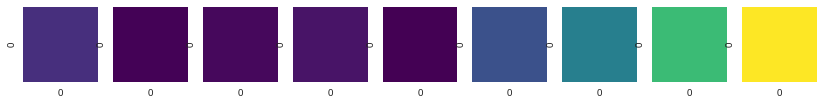

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


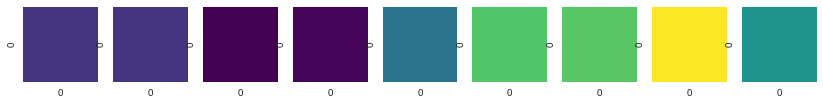

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 11.101795196533203 | 0.155 | 0.04729999601840973  |
|   0   | 11.103896141052246 |  0.15 | 0.061900001019239426 |
|   1   | 11.107233047485352 | 0.165 |  0.0964999869465828  |
+-------+--------------------+-------+----------------------+


In [26]:
# max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


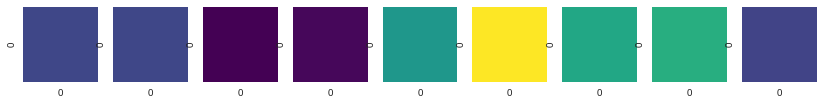

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 10.454754829406738 | 0.125 | 0.05795000120997429  |
|   0   | 10.44267463684082  |  0.16 | 0.052449993789196014 |
|   1   | 10.528153419494629 |  0.15 |  0.0669499933719635  |
+-------+--------------------+-------+----------------------+


In [27]:
# max/min
x = get_layer_avgs(ladel_removed)
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


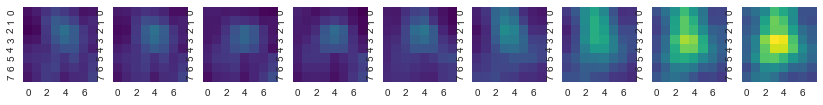

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


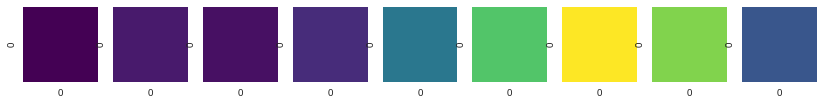

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  | 11.101436614990234 | 0.145 | 0.04534999281167984 |
|   0   | 11.102633476257324 |  0.16 | 0.05144999921321869 |
|   1   | 11.104903221130371 | 0.195 |  0.0775499939918518 |
+-------+--------------------+-------+---------------------+


In [28]:
# pre-avg 3d max-min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


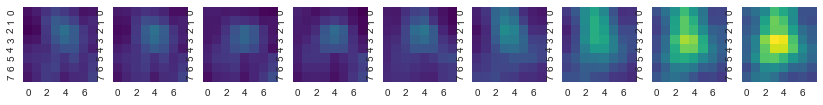

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


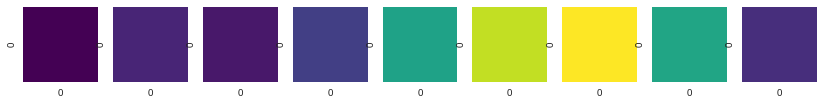

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 10.411490440368652 |  0.19 | 0.05354999378323555  |
|   0   | 10.36600112915039  | 0.145 | 0.043449997901916504 |
|   1   | 10.404990196228027 |  0.14 | 0.053349994122982025 |
+-------+--------------------+-------+----------------------+


In [29]:
# pre-avg 3d max/min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


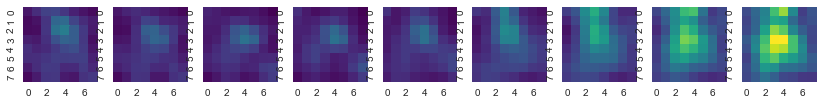

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


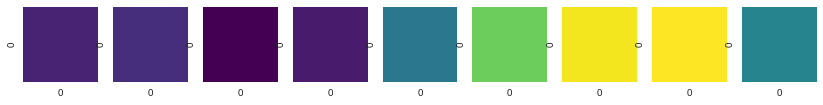

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  | 11.101888656616211 | 0.135 | 0.04784999415278435 |
|   0   | 11.103514671325684 | 0.145 | 0.06094999238848686 |
|   1   | 11.10624885559082  |  0.2  | 0.09404999017715454 |
+-------+--------------------+-------+---------------------+


In [30]:
# pre-gaiss 3d max-min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


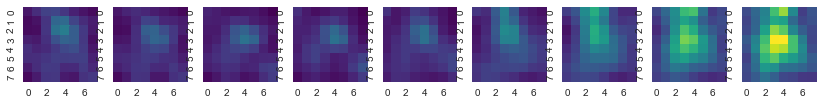

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


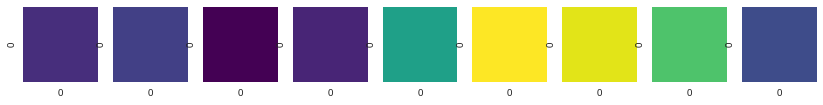

+-------+--------------------+------+---------------------+
| Start |   Int class loss   |  Acc |       Fill MSE      |
+-------+--------------------+------+---------------------+
|   -1  | 10.446338653564453 | 0.13 | 0.05899999290704727 |
|   0   | 10.425281524658203 | 0.16 | 0.05259999260306358 |
|   1   | 10.490924835205078 | 0.15 | 0.06619999557733536 |
+-------+--------------------+------+---------------------+


In [31]:
# pre-gauss 3d max/min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


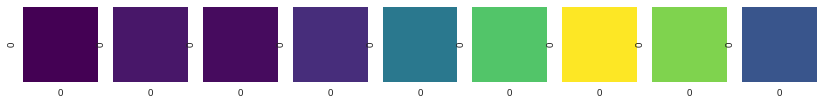

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 11.101860046386719 |  0.14 | 0.046699997037649155 |
|   0   | 11.103052139282227 | 0.155 | 0.05310000106692314  |
|   1   | 11.105259895324707 | 0.195 |  0.0794999897480011  |
+-------+--------------------+-------+----------------------+


In [32]:
# avg 1d max-min
x = get_layer_avgs(ladel_removed)
x = get_1d_avg(x)
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


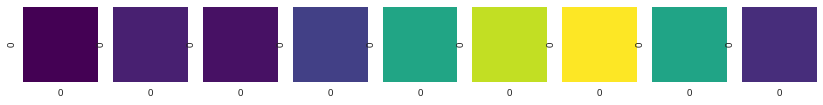

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 10.42704963684082  | 0.175 | 0.053099993616342545 |
|   0   | 10.388885498046875 |  0.17 | 0.043299995362758636 |
|   1   |  10.4319429397583  |  0.13 | 0.053499992936849594 |
+-------+--------------------+-------+----------------------+


In [33]:
# avg 1d max/min
x = get_layer_avgs(ladel_removed)
x = get_1d_avg(x)
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


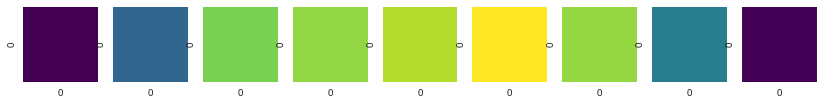

+-------+-------------------+-------+----------------------+
| Start |   Int class loss  |   Acc |       Fill MSE       |
+-------+-------------------+-------+----------------------+
|   -1  | 6.697572231292725 | 0.175 | 0.053099993616342545 |
|   0   | 6.459840297698975 |  0.17 | 0.043299995362758636 |
|   1   | 6.805875778198242 |  0.13 | 0.053499992936849594 |
+-------+-------------------+-------+----------------------+


In [94]:
# avg 1d max/min
x = get_layer_avgs(ladel_removed)
x = get_1d_avg(x)
x = get_max_div_mean(x)*1e4
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


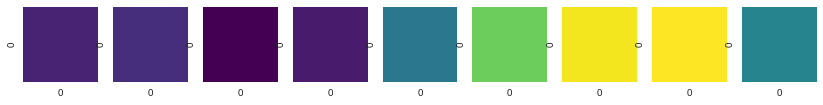

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  | 11.101888656616211 | 0.135 | 0.04784999415278435 |
|   0   | 11.103514671325684 | 0.145 | 0.06094999238848686 |
|   1   | 11.10624885559082  |  0.2  | 0.09404999017715454 |
+-------+--------------------+-------+---------------------+


In [34]:
# gaussg 1d max-min
x = get_layer_avgs(ladel_removed)
x = get_1d_gauss(x)
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


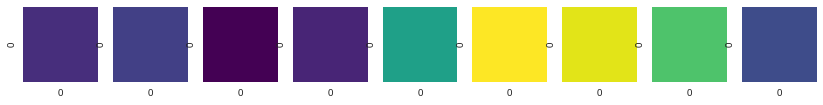

+-------+--------------------+------+---------------------+
| Start |   Int class loss   |  Acc |       Fill MSE      |
+-------+--------------------+------+---------------------+
|   -1  | 10.446338653564453 | 0.13 | 0.05899999290704727 |
|   0   | 10.425281524658203 | 0.16 | 0.05259999260306358 |
|   1   | 10.490924835205078 | 0.15 | 0.06619999557733536 |
+-------+--------------------+------+---------------------+


In [35]:
# gauss 1d max/min
x = get_layer_avgs(ladel_removed)
x = get_1d_gauss(x)
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


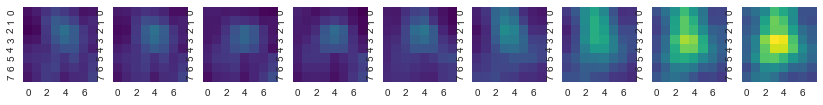

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


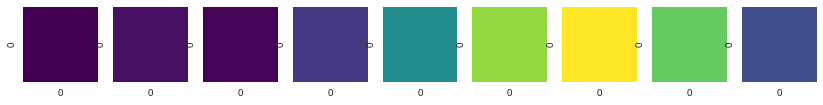

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  | 11.102094650268555 | 0.155 | 0.04404999688267708 |
|   0   | 11.102987289428711 | 0.155 | 0.04715000092983246 |
|   1   | 11.104837417602539 |  0.18 | 0.07024998962879181 |
+-------+--------------------+-------+---------------------+


In [36]:
# pre-avg 3d avg 1d max-min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
x = get_1d_avg(x)
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


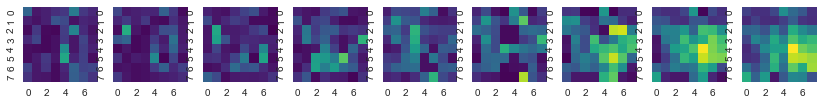

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


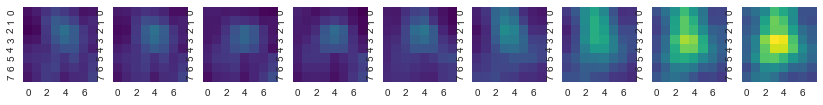

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


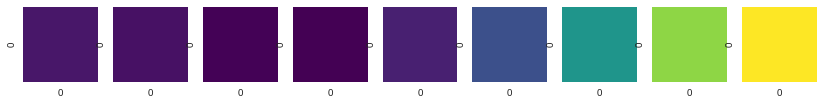

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


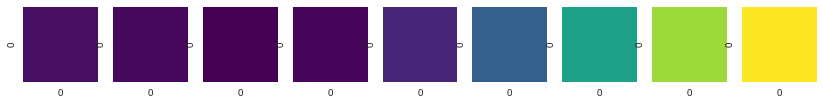

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


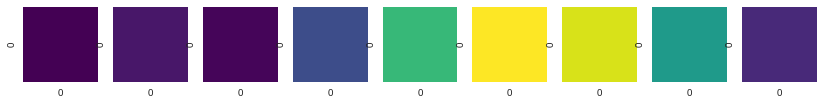

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 10.468337059020996 |  0.13 | 0.056249991059303284 |
|   0   | 10.419475555419922 | 0.165 | 0.04454999417066574  |
|   1   | 10.441932678222656 | 0.155 | 0.05284999683499336  |
+-------+--------------------+-------+----------------------+


In [37]:
# pre-avg 3d avg 1d max/min
plot_pred(ladel_removed[0], targs[0])
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

## Ridge -1,x,-1

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


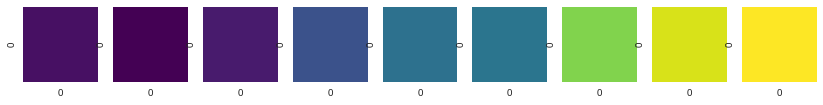

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


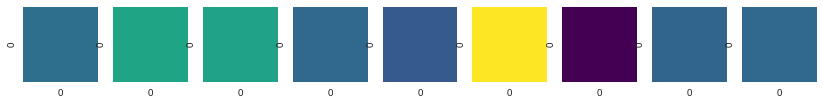

+-------+--------------------+------+---------------------+
| Start |   Int class loss   |  Acc |       Fill MSE      |
+-------+--------------------+------+---------------------+
|   -1  | 11.110860824584961 | 0.1  | 0.09219998121261597 |
|   0   | 11.108904838562012 | 0.15 |  0.0851999968290329 |
|   1   | 11.10706901550293  | 0.12 |  0.0981999859213829 |
+-------+--------------------+------+---------------------+


In [47]:
# Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


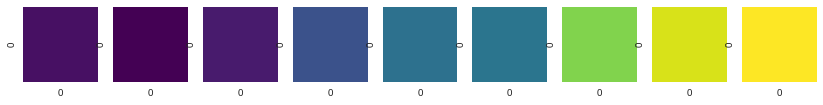

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


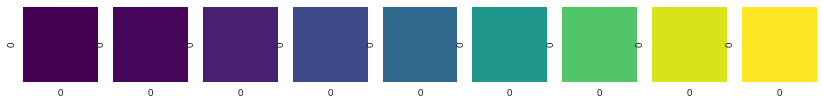

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


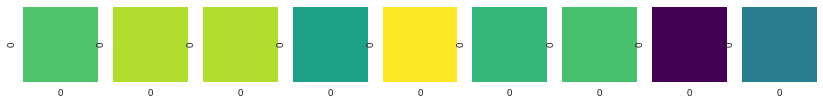

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  | 11.111414909362793 | 0.075 | 0.10984999686479568 |
|   0   | 11.109933853149414 |  0.13 |  0.0807499960064888 |
|   1   | 11.10836410522461  | 0.145 | 0.07164999842643738 |
+-------+--------------------+-------+---------------------+


In [58]:
# 1d avg Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


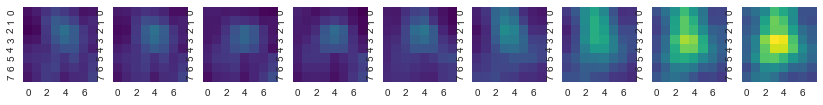

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


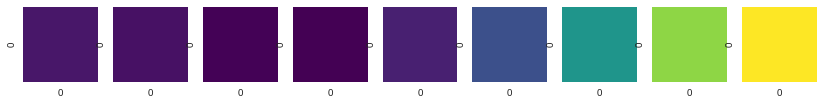

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


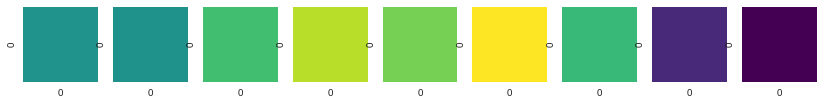

+-------+--------------------+------+---------------------+
| Start |   Int class loss   |  Acc |       Fill MSE      |
+-------+--------------------+------+---------------------+
|   -1  | 11.111469268798828 | 0.08 | 0.10539998859167099 |
|   0   | 11.109918594360352 | 0.13 | 0.07719999551773071 |
|   1   | 11.10827350616455  | 0.13 |  0.0689999908208847 |
+-------+--------------------+------+---------------------+


In [40]:
# 3d avg Ridge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


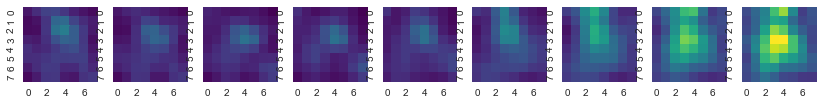

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


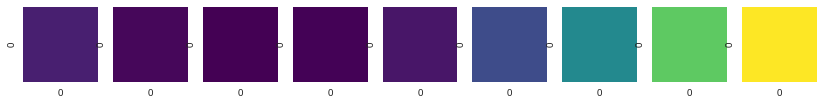

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


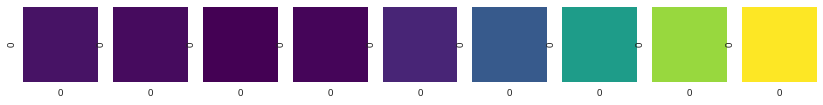

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


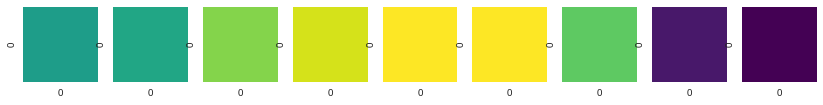

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 11.111483573913574 | 0.075 |  0.1148500069975853  |
|   0   | 11.110079765319824 |  0.13 | 0.07794999331235886  |
|   1   | 11.108616828918457 |  0.13 | 0.061049994081258774 |
+-------+--------------------+-------+----------------------+


In [41]:
# 3d avg 1d avg Ridge
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


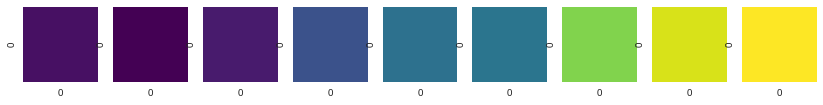

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


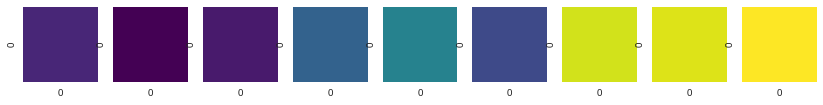

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


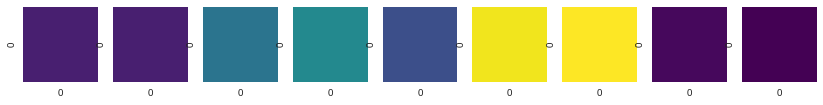

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  | 11.090719223022461 |  0.16 | 0.04704999551177025 |
|   0   | 11.097352027893066 | 0.155 | 0.06214999780058861 |
|   1   | 11.10669231414795  | 0.165 | 0.09724999219179153 |
+-------+--------------------+-------+---------------------+


In [48]:
# Ridge max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,4,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


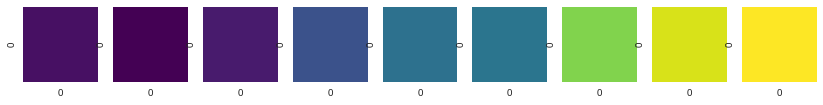

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


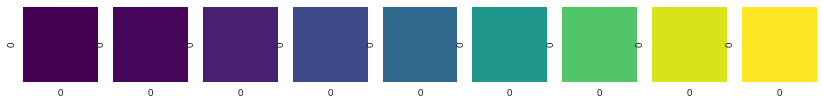

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


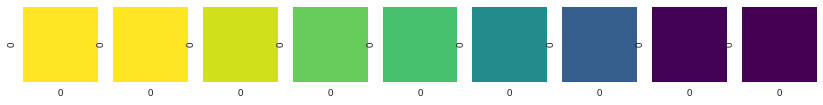

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


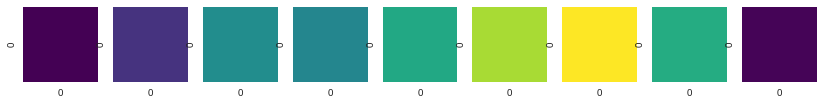

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  |   11.09130859375   | 0.165 | 0.048899997025728226 |
|   0   | 11.094278335571289 |  0.13 | 0.05849999934434891  |
|   1   | 11.09939193725586  |  0.21 | 0.08809999376535416  |
+-------+--------------------+-------+----------------------+


In [49]:
# 1d avg Ridge max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,4,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


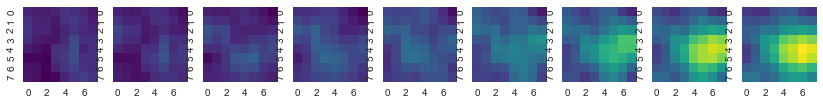

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


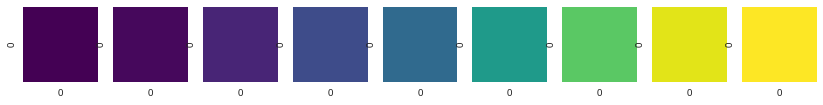

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


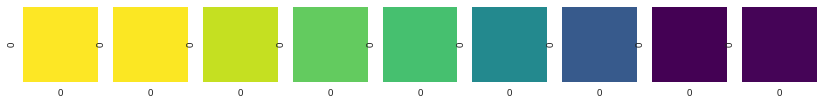

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


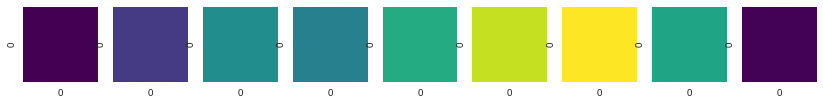

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  | 11.090367317199707 |  0.16 |  0.0478999949991703 |
|   0   | 11.093358993530273 | 0.125 | 0.05629999563097954 |
|   1   |   11.0986328125    |  0.21 | 0.08469999581575394 |
+-------+--------------------+-------+---------------------+


In [50]:
# 3d avg Ridge max-min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,4,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


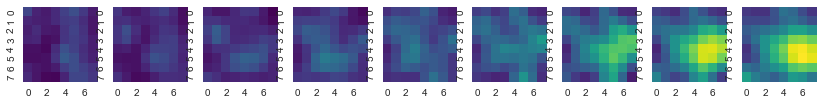

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


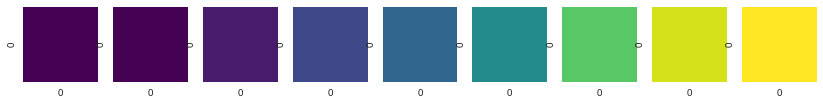

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


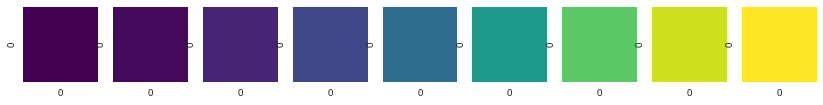

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


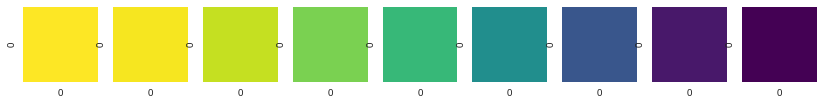

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


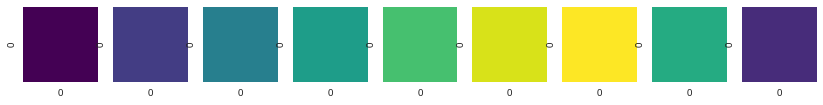

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  | 11.091629981994629 | 0.155 | 0.04674999415874481 |
|   0   | 11.09424114227295  |  0.15 | 0.05365000292658806 |
|   1   | 11.098980903625488 | 0.165 | 0.08054998517036438 |
+-------+--------------------+-------+---------------------+


In [51]:
# 3d avg 1d avg Ridge max-min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,4,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


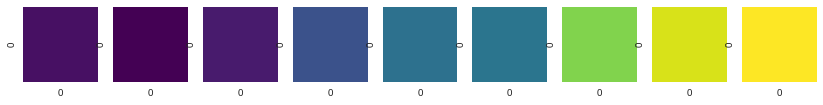

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


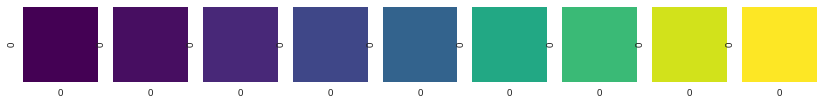

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


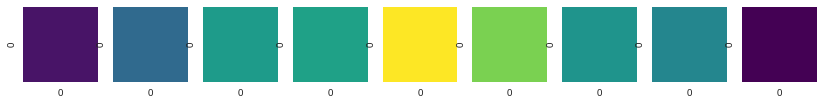

+-------+--------------------+------+---------------------+
| Start |   Int class loss   |  Acc |       Fill MSE      |
+-------+--------------------+------+---------------------+
|   -1  | 10.45883560180664  | 0.14 | 0.05334999039769173 |
|   0   | 10.416094779968262 | 0.13 | 0.04384999722242355 |
|   1   | 10.444474220275879 | 0.2  | 0.05434999614953995 |
+-------+--------------------+------+---------------------+


In [54]:
# Ridge max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,0,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


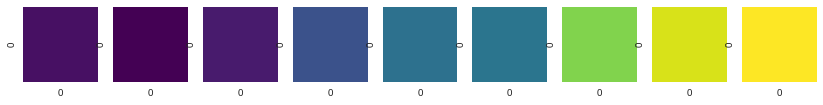

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


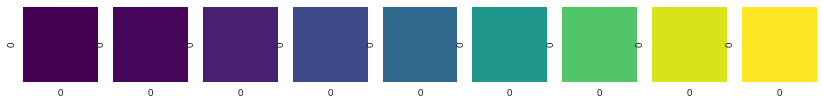

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


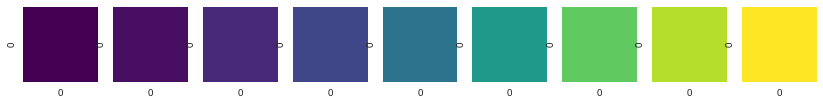

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


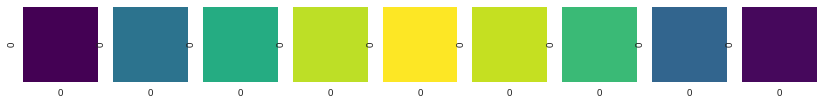

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 10.522360801696777 | 0.105 | 0.056749992072582245 |
|   0   | 10.477612495422363 | 0.175 | 0.043449994176626205 |
|   1   | 10.497415542602539 |  0.16 | 0.05014999210834503  |
+-------+--------------------+-------+----------------------+


In [55]:
# 1d avg Ridge max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,0,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


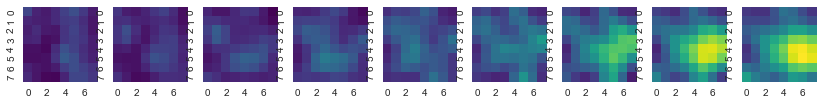

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


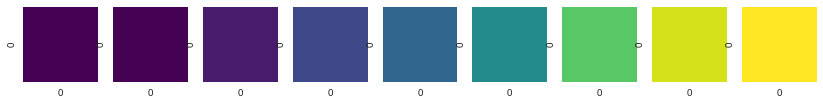

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


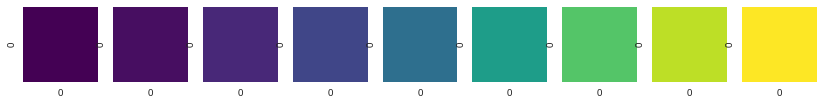

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


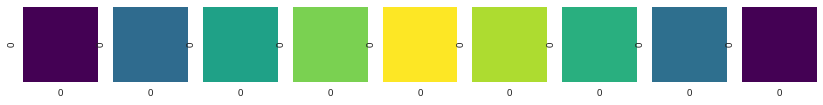

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  | 10.485401153564453 | 0.145 | 0.05249999463558197 |
|   0   | 10.447210311889648 |  0.13 | 0.04209999740123749 |
|   1   | 10.478014945983887 | 0.185 | 0.05169999599456787 |
+-------+--------------------+-------+---------------------+


In [56]:
# 3d avg Ridge max/min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,0,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


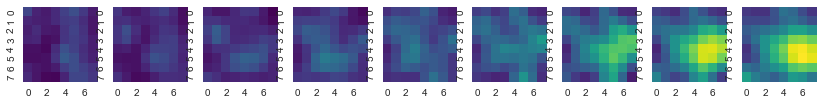

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


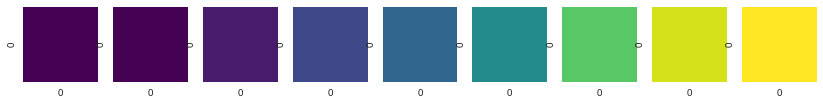

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


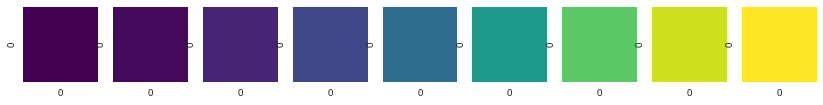

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


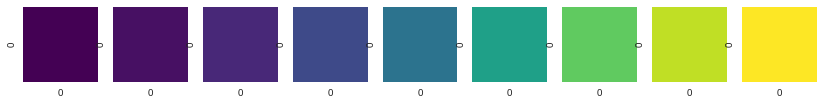

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


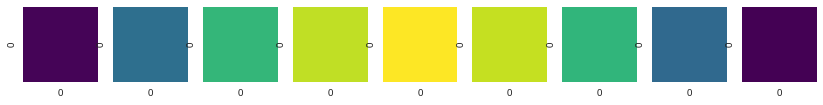

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 10.553853988647461 |  0.1  | 0.05570000037550926  |
|   0   | 10.509552955627441 | 0.185 | 0.04229999706149101  |
|   1   | 10.523693084716797 |  0.16 | 0.048899997025728226 |
+-------+--------------------+-------+----------------------+


In [57]:
# 3d avg 1d avg Ridge max/min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,0,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


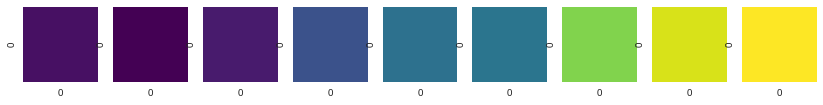

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


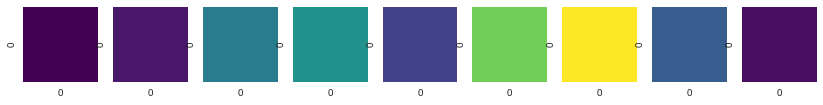

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


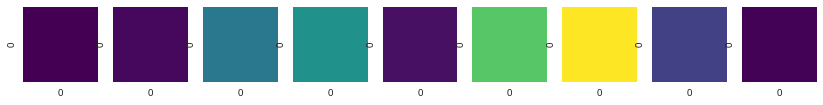

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  | 11.052324295043945 |  0.17 | 0.04714999347925186 |
|   0   | 11.065007209777832 | 0.145 | 0.06224999576807022 |
|   1   | 11.085807800292969 | 0.165 | 0.09734998643398285 |
+-------+--------------------+-------+---------------------+


In [63]:
# max-min Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,8,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


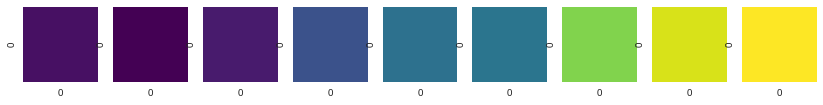

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


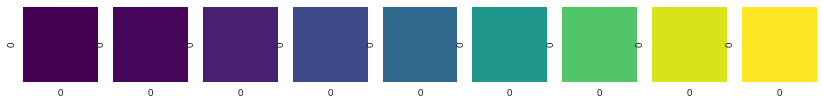

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


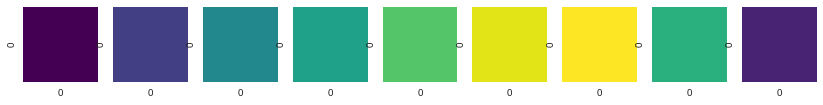

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


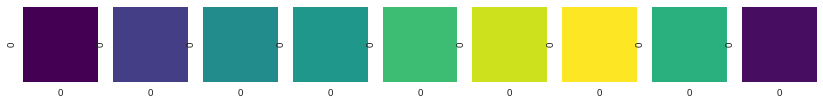

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 11.052617073059082 | 0.155 | 0.047099992632865906 |
|   0   |  11.0596342086792  | 0.135 | 0.05469999462366104  |
|   1   | 11.073073387145996 |  0.21 | 0.08229999244213104  |
+-------+--------------------+-------+----------------------+


In [59]:
# 1d avg max-min Ridge 
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,8,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


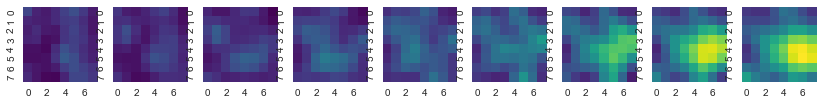

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


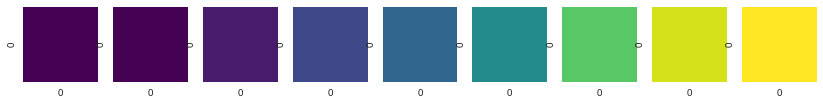

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


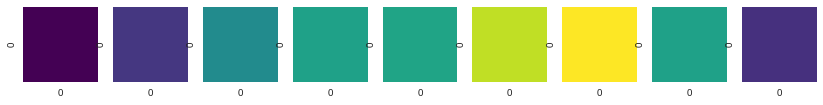

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


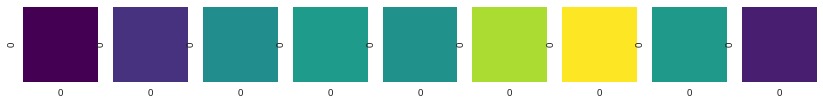

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  | 11.052950859069824 |  0.15 |  0.0471000000834465 |
|   0   | 11.062651634216309 | 0.155 | 0.06189998611807823 |
|   1   | 11.079450607299805 |  0.19 | 0.09669999033212662 |
+-------+--------------------+-------+---------------------+


In [64]:
# 3d avg max-min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,8,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


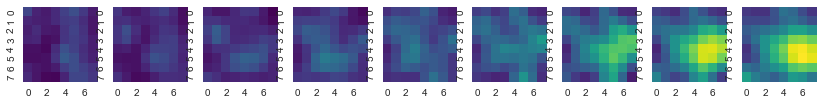

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


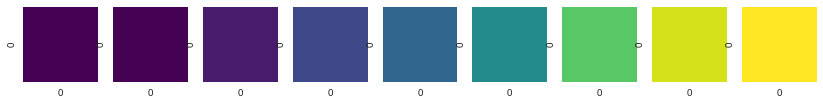

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


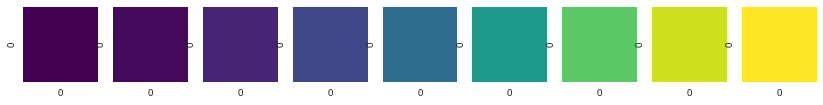

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


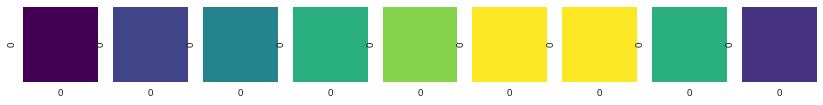

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


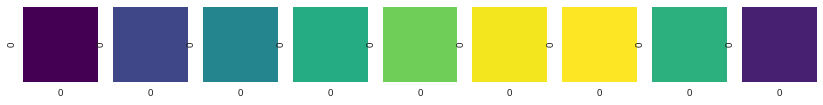

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 11.05469036102295  |  0.15 | 0.046149998903274536 |
|   0   | 11.060882568359375 |  0.15 | 0.051649998873472214 |
|   1   | 11.073095321655273 | 0.175 | 0.07714999467134476  |
+-------+--------------------+-------+----------------------+


In [65]:
# 3d avg 1d avg max-min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,8,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


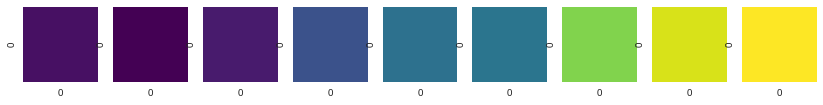

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


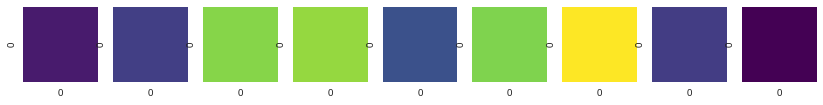

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


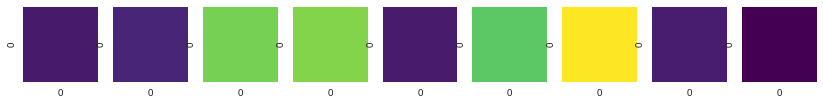

+-------+-------------------+------+----------------------+
| Start |   Int class loss  |  Acc |       Fill MSE       |
+-------+-------------------+------+----------------------+
|   -1  | 8.044812202453613 | 0.12 | 0.05925000086426735  |
|   0   | 7.975054740905762 | 0.16 | 0.053749993443489075 |
|   1   | 8.280533790588379 | 0.17 | 0.06824998557567596  |
+-------+-------------------+------+----------------------+


In [72]:
# max/min Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,8,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


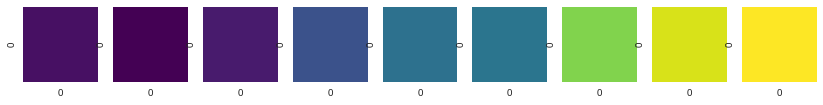

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


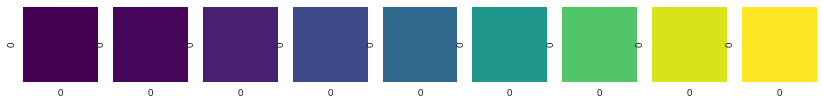

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


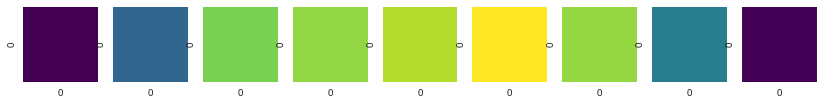

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


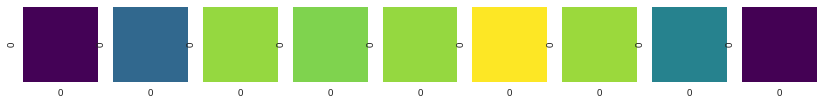

+-------+--------------------+------+----------------------+
| Start |   Int class loss   |  Acc |       Fill MSE       |
+-------+--------------------+------+----------------------+
|   -1  | 7.9685187339782715 | 0.19 | 0.054799988865852356 |
|   0   | 7.7652764320373535 | 0.14 | 0.04479999095201492  |
|   1   | 7.914648056030273  | 0.15 | 0.05479999631643295  |
+-------+--------------------+------+----------------------+


In [73]:
# 1d avg max/min Ridge 
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,8,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


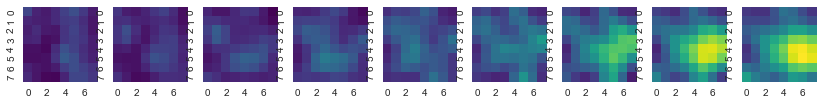

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


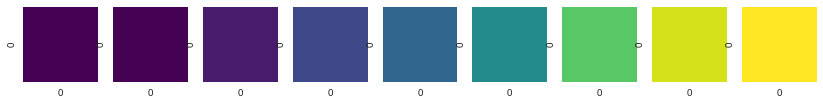

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


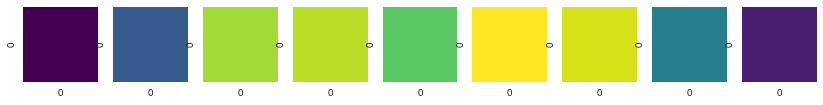

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


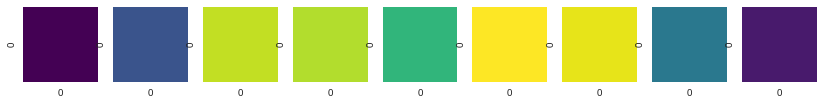

+-------+-------------------+-------+----------------------+
| Start |   Int class loss  |   Acc |       Fill MSE       |
+-------+-------------------+-------+----------------------+
|   -1  | 8.026510238647461 | 0.115 | 0.059199996292591095 |
|   0   | 7.920738697052002 | 0.165 | 0.05279999598860741  |
|   1   | 8.173473358154297 |  0.16 | 0.06639998406171799  |
+-------+-------------------+-------+----------------------+


In [74]:
# 3d avg max/min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,8,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


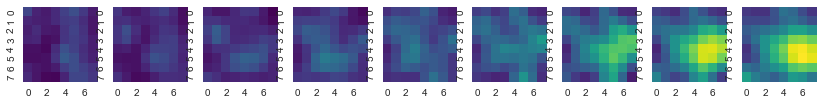

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


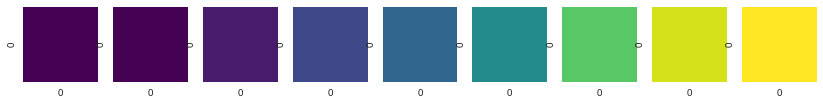

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


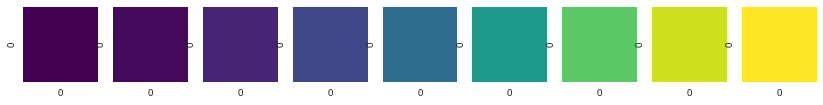

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


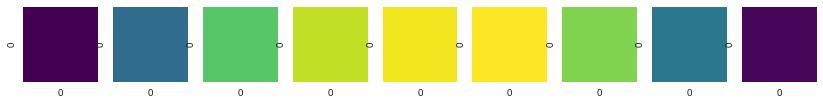

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


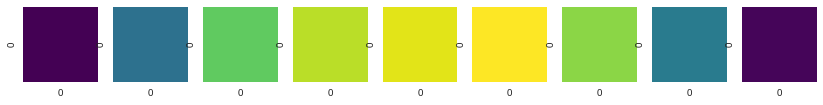

+-------+-------------------+-------+----------------------+
| Start |   Int class loss  |   Acc |       Fill MSE       |
+-------+-------------------+-------+----------------------+
|   -1  |  8.06784439086914 | 0.165 | 0.05329999327659607  |
|   0   | 7.838751316070557 |  0.15 | 0.04349999874830246  |
|   1   | 7.961644172668457 | 0.145 | 0.053700000047683716 |
+-------+-------------------+-------+----------------------+


In [75]:
# 3d avg 1d avg max/min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,8,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

## Directed edge

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


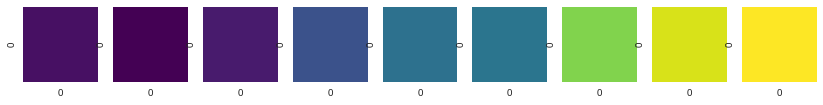

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


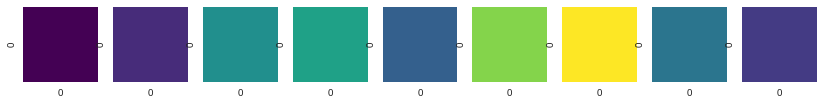

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 11.097683906555176 | 0.155 | 0.04729999601840973  |
|   0   | 11.099565505981445 |  0.15 | 0.061900001019239426 |
|   1   | 11.103375434875488 | 0.165 |  0.0964999869465828  |
+-------+--------------------+-------+----------------------+


In [63]:
# Edge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


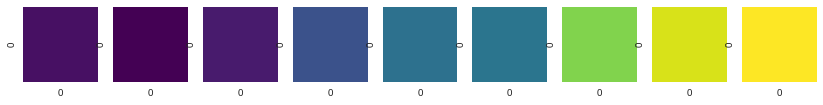

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


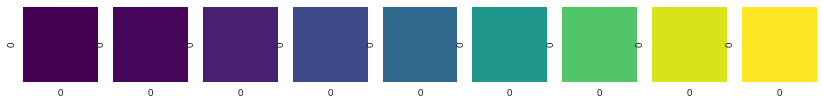

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


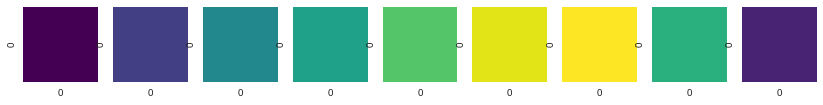

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  |  11.100341796875   |  0.14 | 0.046699997037649155 |
|   0   | 11.10129165649414  | 0.155 | 0.05310000106692314  |
|   1   | 11.103540420532227 | 0.195 |  0.0794999897480011  |
+-------+--------------------+-------+----------------------+


In [64]:
# 1d avg Edge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


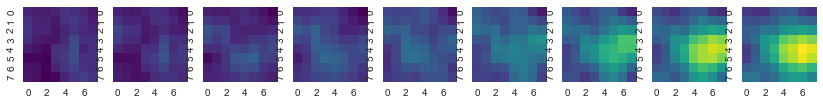

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


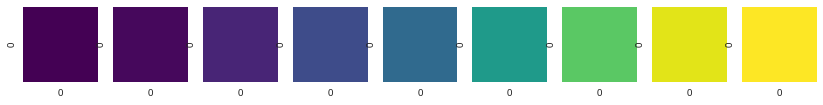

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


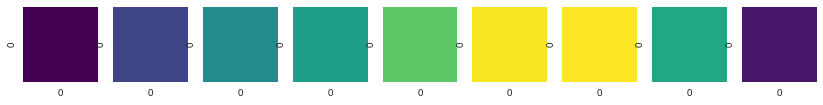

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  | 11.09986686706543  | 0.145 | 0.04534999281167984 |
|   0   | 11.100805282592773 |  0.16 | 0.05144999921321869 |
|   1   | 11.103114128112793 | 0.195 |  0.0775499939918518 |
+-------+--------------------+-------+---------------------+


In [65]:
# 3d avg Edge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


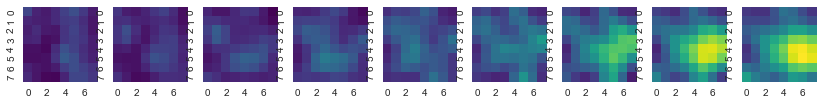

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


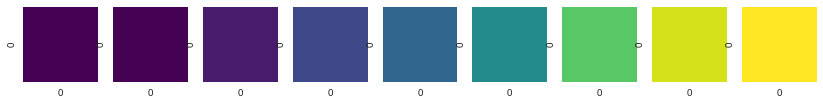

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


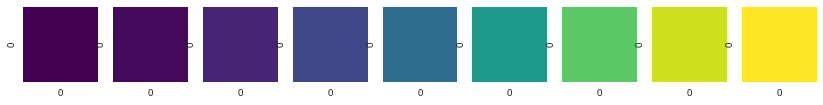

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


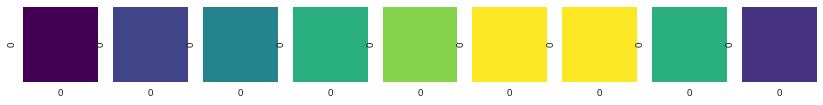

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 11.10110092163086  |  0.14 | 0.046349991112947464 |
|   0   | 11.101946830749512 | 0.155 | 0.05145000293850899  |
|   1   | 11.103952407836914 | 0.175 | 0.07654999196529388  |
+-------+--------------------+-------+----------------------+


In [66]:
# 3d avg 1d avg Edge
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


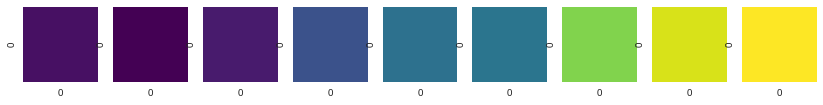

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


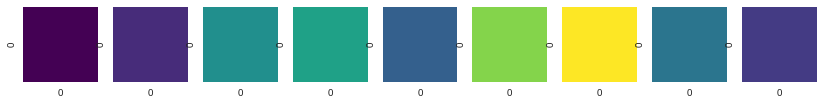

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


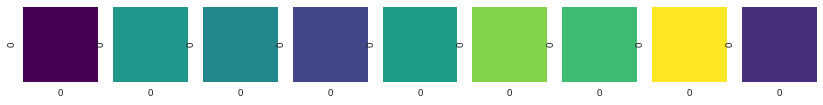

+-------+--------------------+------+---------------------+
| Start |   Int class loss   |  Acc |       Fill MSE      |
+-------+--------------------+------+---------------------+
|   -1  | 11.105299949645996 | 0.12 | 0.09544999897480011 |
|   0   | 11.106695175170898 | 0.11 | 0.08574999868869781 |
|   1   | 11.108484268188477 | 0.06 | 0.09604999423027039 |
+-------+--------------------+------+---------------------+


In [67]:
# Ridge max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


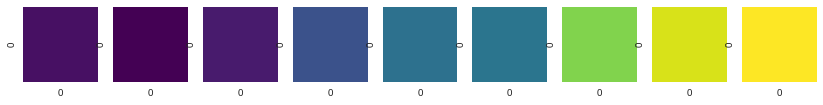

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


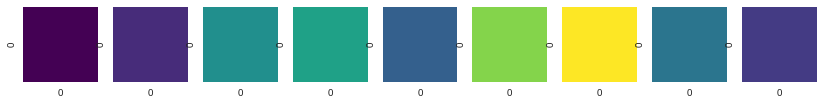

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


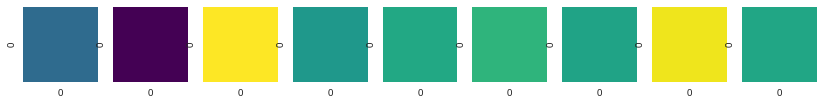

+-------+-------------------+-------+---------------------+
| Start |   Int class loss  |   Acc |       Fill MSE      |
+-------+-------------------+-------+---------------------+
|   -1  | 9.177804946899414 | 0.075 |  0.0880499929189682 |
|   0   |  9.00914478302002 | 0.185 | 0.07294999063014984 |
|   1   |  9.2787504196167  |  0.11 | 0.07784999907016754 |
+-------+-------------------+-------+---------------------+


In [33]:
# Ridge max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


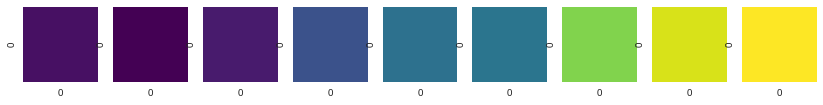

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


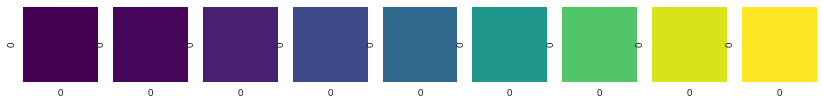

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


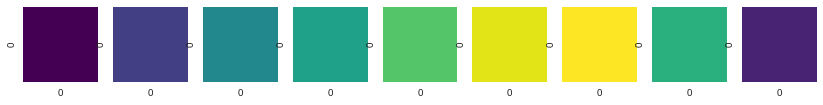

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


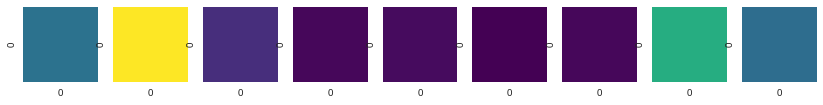

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  |  11.1578950881958  | 0.085 |  0.1335499882698059 |
|   0   | 10.674757957458496 | 0.115 | 0.10684998333454132 |
|   1   | 10.230779647827148 | 0.115 | 0.10014999657869339 |
+-------+--------------------+-------+---------------------+


In [32]:
# 1d avg Ridge max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


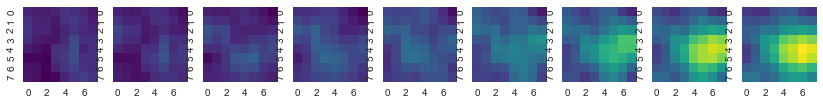

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


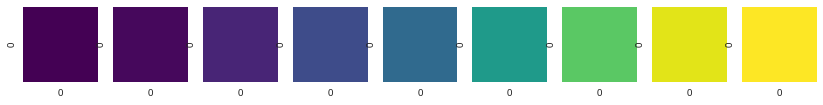

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


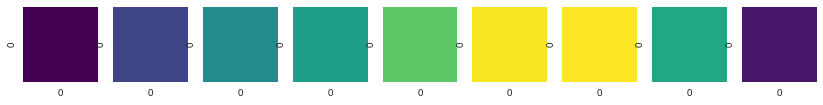

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


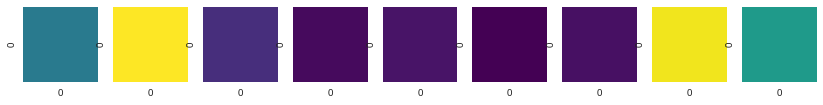

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  | 11.195673942565918 | 0.085 | 0.13580000400543213 |
|   0   | 10.664180755615234 |  0.11 | 0.10779998451471329 |
|   1   | 10.167025566101074 | 0.135 |  0.0998000055551529 |
+-------+--------------------+-------+---------------------+


In [70]:
# 3d avg Ridge max/min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


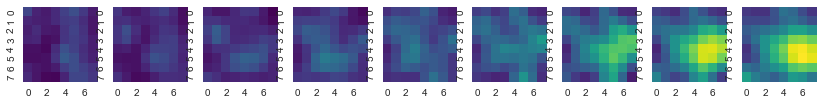

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


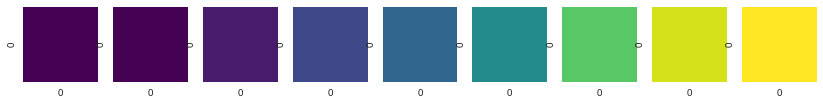

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


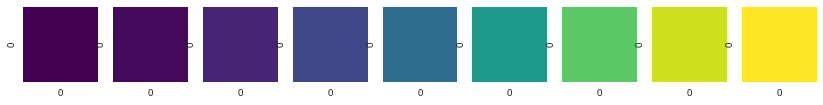

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


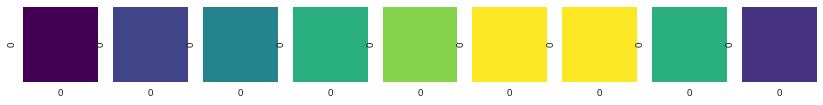

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


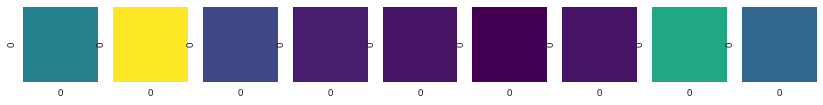

+-------+--------------------+------+---------------------+
| Start |   Int class loss   |  Acc |       Fill MSE      |
+-------+--------------------+------+---------------------+
|   -1  | 12.265951156616211 | 0.05 | 0.15139999985694885 |
|   0   | 11.206265449523926 | 0.1  | 0.11159998923540115 |
|   1   | 10.109508514404297 | 0.13 | 0.09179999679327011 |
+-------+--------------------+------+---------------------+


In [71]:
# 3d avg 1d avg Ridge max/min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


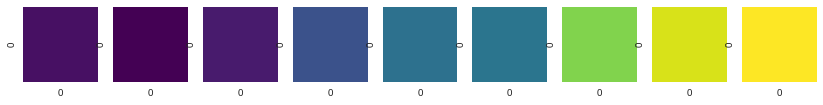

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


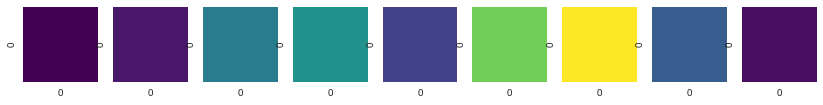

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


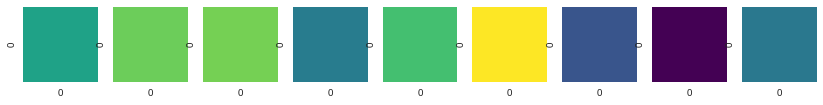

+-------+--------------------+------+---------------------+
| Start |   Int class loss   |  Acc |       Fill MSE      |
+-------+--------------------+------+---------------------+
|   -1  | 11.109618186950684 | 0.12 | 0.07829999178647995 |
|   0   | 11.10567855834961  | 0.13 | 0.05849999934434891 |
|   1   | 11.102248191833496 | 0.14 | 0.05869999900460243 |
+-------+--------------------+------+---------------------+


In [72]:
# max-min Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


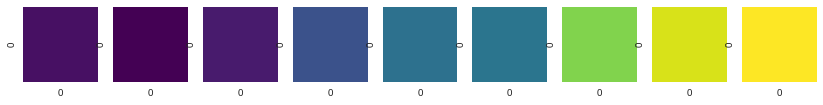

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


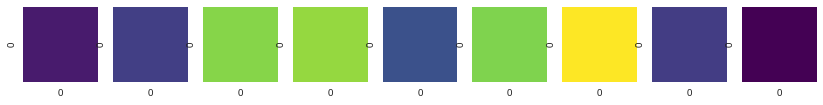

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


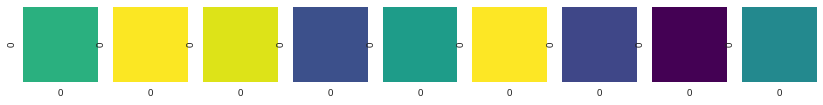

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 11.259055137634277 |  0.07 | 0.10925000160932541  |
|   0   | 10.916006088256836 | 0.115 | 0.07575000077486038  |
|   1   | 10.57562255859375  | 0.165 | 0.062249988317489624 |
+-------+--------------------+-------+----------------------+


In [73]:
# max/min Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


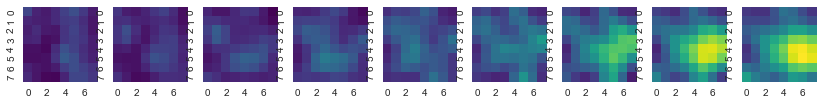

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


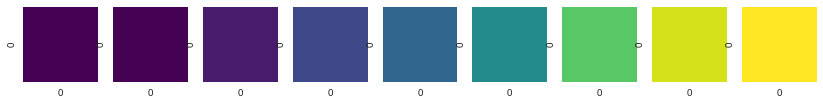

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


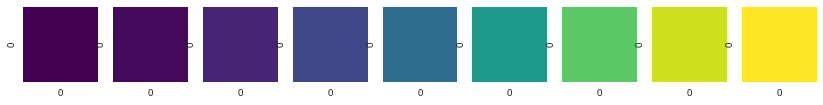

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


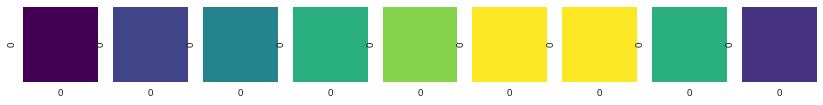

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


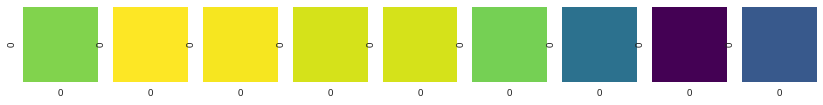

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 11.112364768981934 | 0.075 | 0.10349999368190765  |
|   0   | 11.108366966247559 | 0.145 | 0.06789998710155487  |
|   1   | 11.104300498962402 |  0.16 | 0.052299994975328445 |
+-------+--------------------+-------+----------------------+


In [74]:
# 3d avg 1d avg max-min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


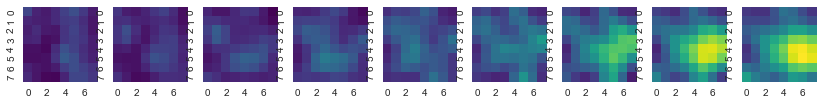

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


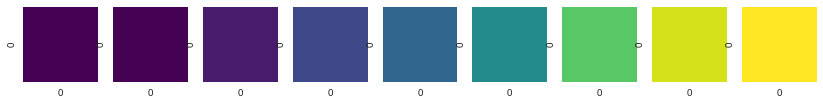

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


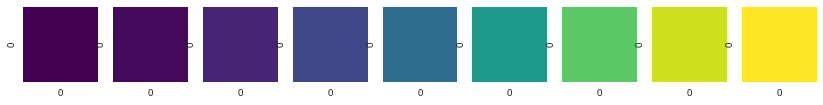

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


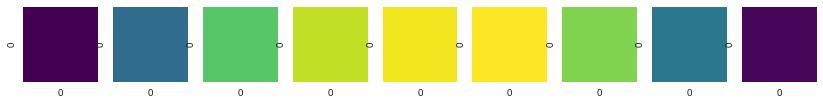

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


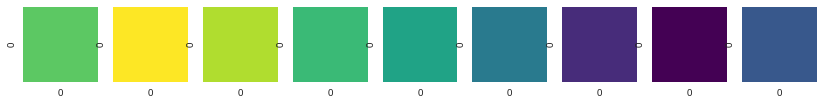

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 11.446755409240723 | 0.065 | 0.12574999034404755  |
|   0   | 11.135570526123047 | 0.145 | 0.07804999500513077  |
|   1   | 10.782822608947754 | 0.135 | 0.050349995493888855 |
+-------+--------------------+-------+----------------------+


In [75]:
# 3d avg 1d avg max/min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


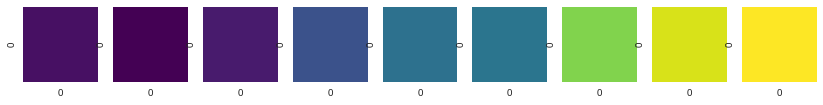

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


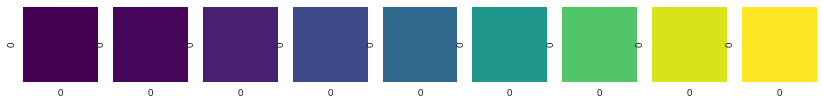

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


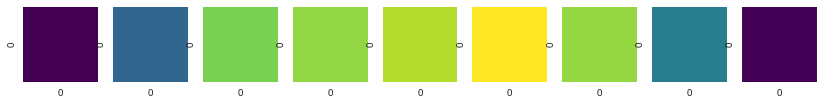

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


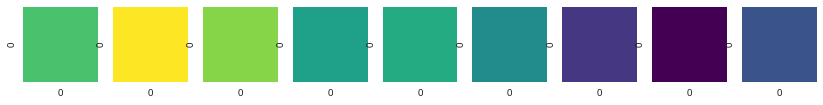

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 11.446518898010254 | 0.065 | 0.12114999443292618  |
|   0   | 11.119503021240234 | 0.135 | 0.07724999636411667  |
|   1   | 10.747950553894043 | 0.115 | 0.053349994122982025 |
+-------+--------------------+-------+----------------------+


In [76]:
# 1d avg max/min Ridge 
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


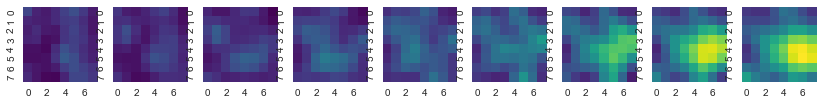

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


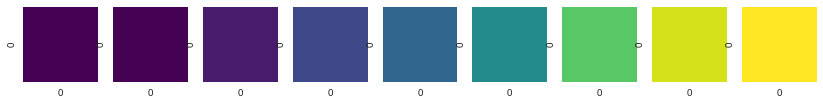

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


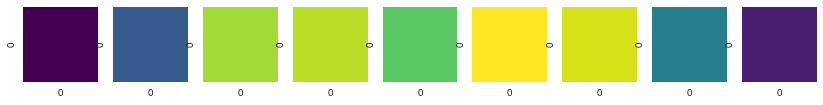

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


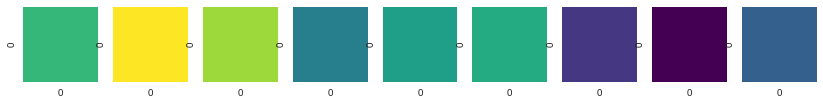

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  |   11.37158203125   |  0.07 | 0.11455000936985016 |
|   0   | 11.04983139038086  | 0.125 | 0.07484999299049377 |
|   1   | 10.696674346923828 |  0.13 | 0.05514999479055405 |
+-------+--------------------+-------+---------------------+


In [77]:
# 3d avg max/min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

## Laplacian edge

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


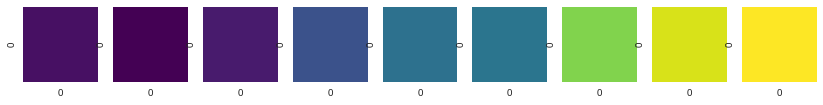

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


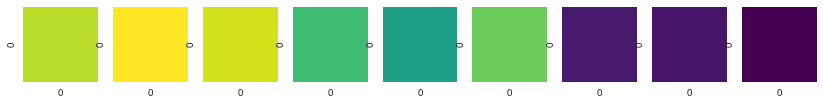

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


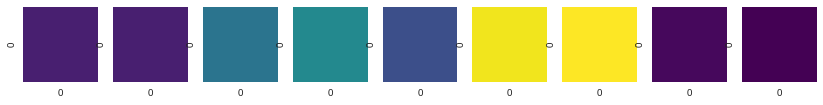

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  | 11.090719223022461 |  0.16 | 0.04704999551177025 |
|   0   | 11.097352027893066 | 0.155 | 0.06214999780058861 |
|   1   | 11.10669231414795  | 0.165 | 0.09724999219179153 |
+-------+--------------------+-------+---------------------+


In [78]:
# Laplacian max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


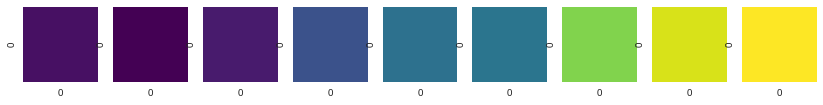

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


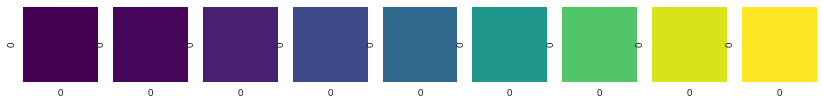

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


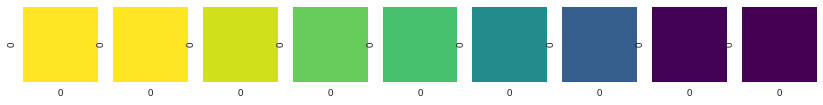

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


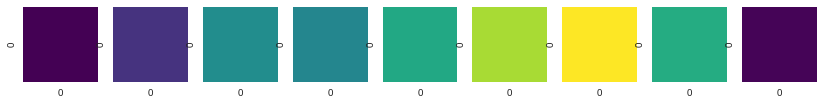

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  |   11.09130859375   | 0.165 | 0.048899997025728226 |
|   0   | 11.094278335571289 |  0.13 | 0.05849999934434891  |
|   1   | 11.09939193725586  |  0.21 | 0.08809999376535416  |
+-------+--------------------+-------+----------------------+


In [79]:
# 1d avg Laplacian max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


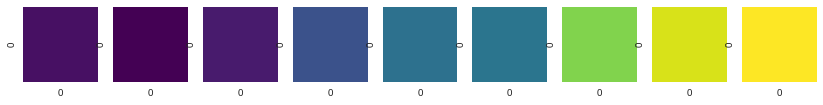

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


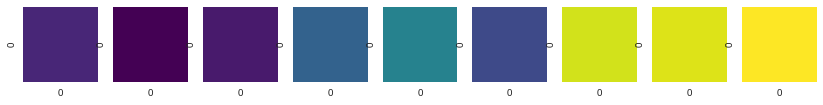

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


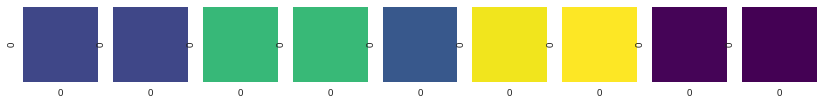

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  | 10.435650825500488 | 0.105 | 0.08689999580383301 |
|   0   | 10.421499252319336 |  0.16 |  0.0754999965429306 |
|   1   | 10.509197235107422 |  0.15 | 0.08410000056028366 |
+-------+--------------------+-------+---------------------+


In [80]:
# Laplacian max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


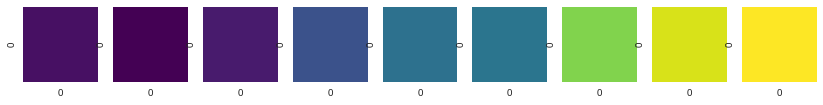

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


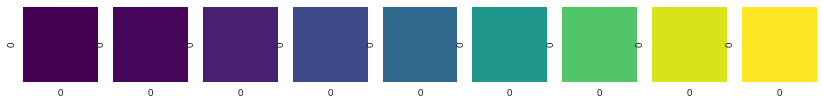

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


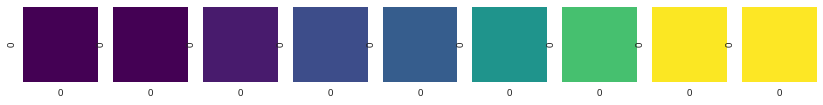

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


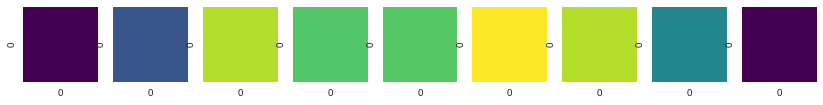

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 10.356925010681152 | 0.165 | 0.05524999648332596  |
|   0   | 10.315106391906738 |  0.15 | 0.04694999381899834  |
|   1   |  10.3670015335083  |  0.16 | 0.058649998158216476 |
+-------+--------------------+-------+----------------------+


In [81]:
# 1d avg Laplacian max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


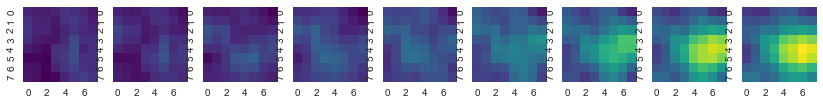

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


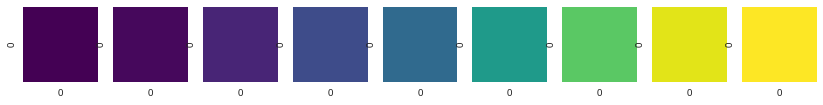

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


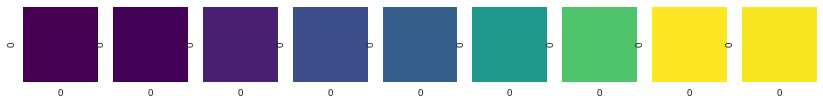

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


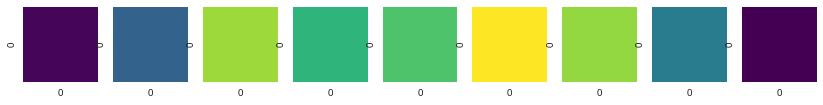

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 10.33626937866211  |  0.18 | 0.054099999368190765 |
|   0   | 10.285017967224121 |  0.13 | 0.04569999873638153  |
|   1   | 10.332829475402832 | 0.175 | 0.05729999393224716  |
+-------+--------------------+-------+----------------------+


In [82]:
# 3d avg Laplacian max/min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


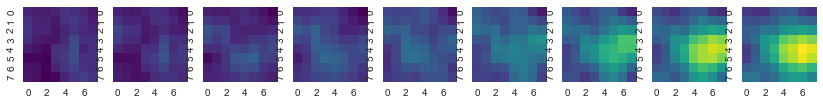

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


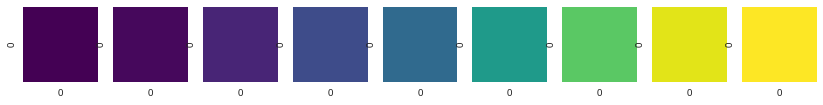

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


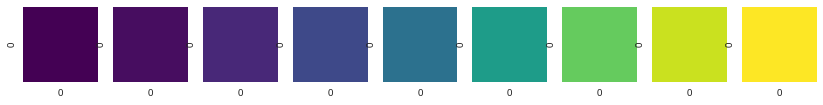

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


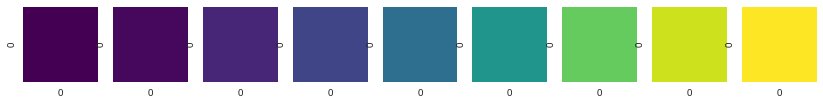

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


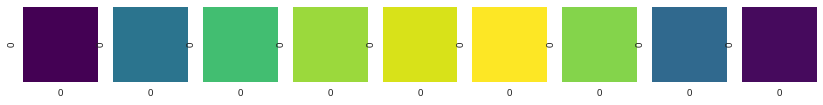

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  | 10.379302024841309 | 0.155 | 0.05339999496936798 |
|   0   | 10.329204559326172 | 0.155 | 0.04359999671578407 |
|   1   | 10.364903450012207 | 0.135 | 0.05380000174045563 |
+-------+--------------------+-------+---------------------+


In [83]:
# 3d avg 1d avg Laplacian max/min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


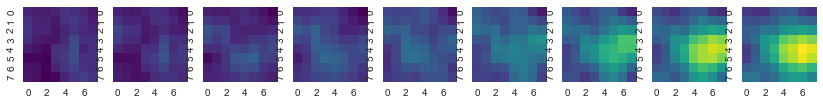

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


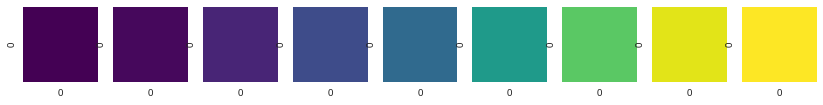

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


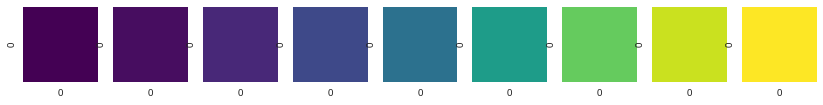

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


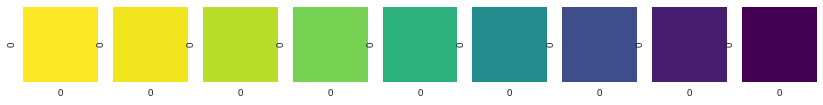

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


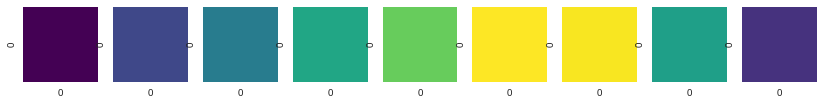

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


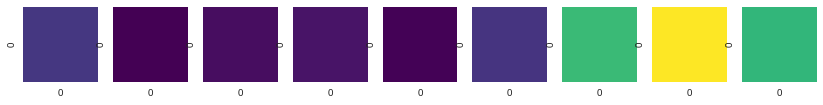

+-------+--------------------+------+---------------------+
| Start |   Int class loss   |  Acc |       Fill MSE      |
+-------+--------------------+------+---------------------+
|   -1  | 11.10827350616455  | 0.15 | 0.06004999205470085 |
|   0   | 11.117469787597656 | 0.16 | 0.09074998646974564 |
|   1   |  11.1267728805542  | 0.14 | 0.14144998788833618 |
+-------+--------------------+------+---------------------+


In [84]:
# 3d avg 1d avg Laplacian max-min edge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [1,0,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


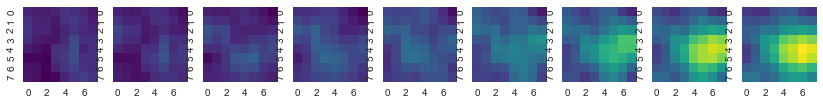

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


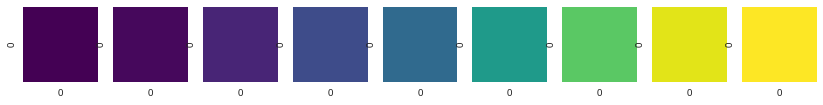

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


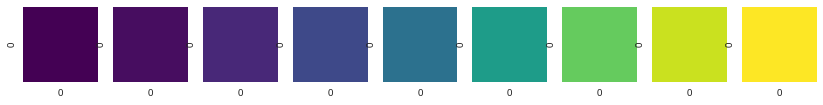

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


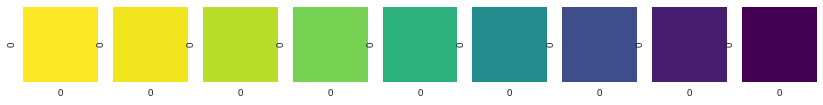

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


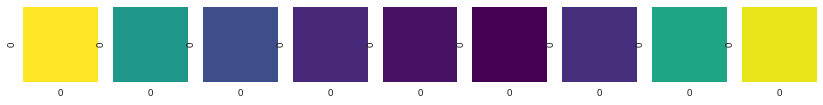

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


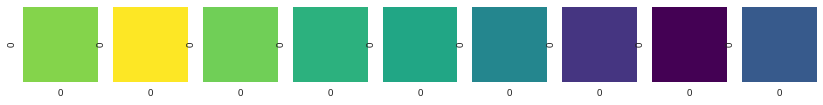

+-------+--------------------+-------+---------------------+
| Start |   Int class loss   |   Acc |       Fill MSE      |
+-------+--------------------+-------+---------------------+
|   -1  | 11.364811897277832 | 0.055 | 0.13490000367164612 |
|   0   | 11.13734245300293  |  0.13 | 0.08370000123977661 |
|   1   | 10.884526252746582 | 0.145 | 0.05249999091029167 |
+-------+--------------------+-------+---------------------+


In [85]:
# 3d avg 1d avg Laplacian max/min edge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [1,0,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


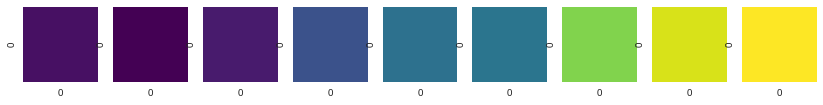

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


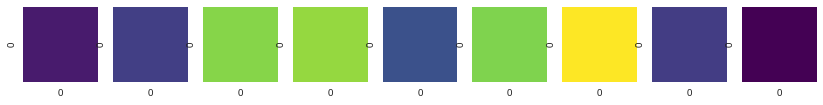

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


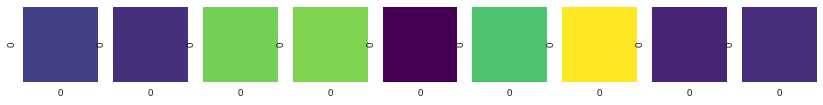

+-------+-------------------+------+---------------------+
| Start |   Int class loss  |  Acc |       Fill MSE      |
+-------+-------------------+------+---------------------+
|   -1  | 9.380541801452637 | 0.11 | 0.06149999797344208 |
|   0   | 9.347485542297363 | 0.17 | 0.05629999563097954 |
|   1   | 9.556241035461426 | 0.16 | 0.07109998911619186 |
+-------+-------------------+------+---------------------+


In [86]:
# max/min Laplacian 
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


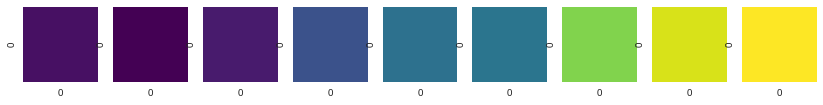

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


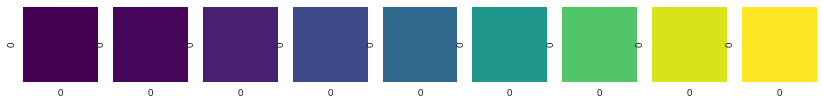

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


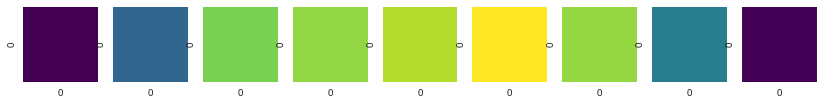

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


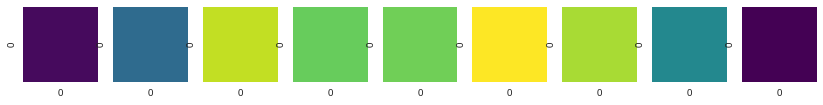

+-------+-------------------+-------+---------------------+
| Start |   Int class loss  |   Acc |       Fill MSE      |
+-------+-------------------+-------+---------------------+
|   -1  | 9.518067359924316 | 0.165 | 0.05644999071955681 |
|   0   | 9.402939796447754 |  0.14 | 0.04714999720454216 |
|   1   | 9.485395431518555 | 0.155 | 0.05784999206662178 |
+-------+-------------------+-------+---------------------+


In [87]:
# 1d avg max/min Laplacian edge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


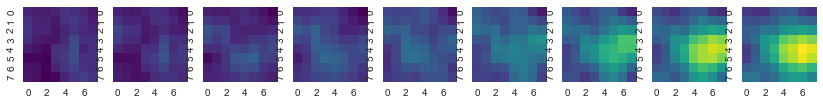

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


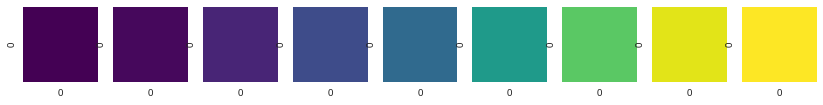

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


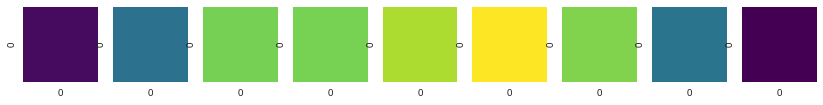

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


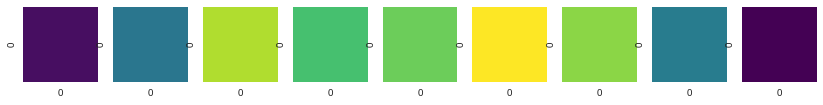

+-------+-------------------+-------+---------------------+
| Start |   Int class loss  |   Acc |       Fill MSE      |
+-------+-------------------+-------+---------------------+
|   -1  | 9.483320236206055 | 0.185 | 0.05639999359846115 |
|   0   | 9.348572731018066 |  0.12 | 0.04599999263882637 |
|   1   | 9.420491218566895 |  0.15 | 0.05559999495744705 |
+-------+-------------------+-------+---------------------+


In [88]:
# 3d avg max/min Laplacian edge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


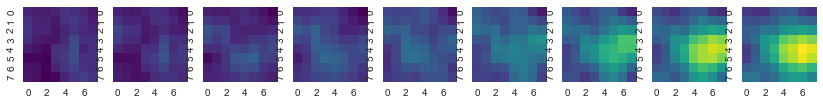

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


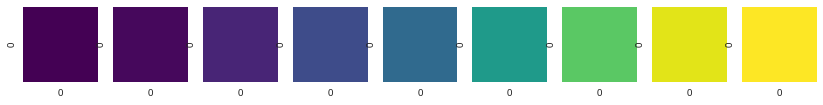

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


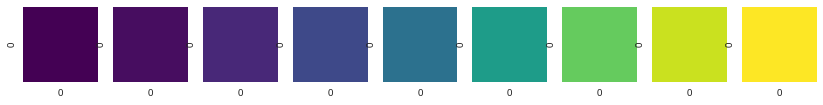

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


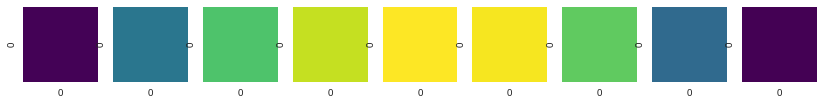

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


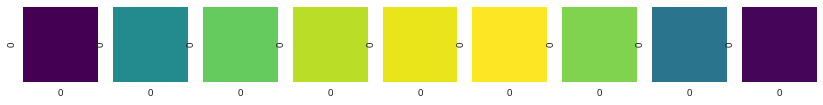

+-------+-------------------+------+----------------------+
| Start |   Int class loss  |  Acc |       Fill MSE       |
+-------+-------------------+------+----------------------+
|   -1  | 9.641368865966797 | 0.16 | 0.055949997156858444 |
|   0   | 9.499887466430664 | 0.16 | 0.044249992817640305 |
|   1   | 9.526627540588379 | 0.13 | 0.05254999175667763  |
+-------+-------------------+------+----------------------+


In [89]:
# 3d avg 1d avg max/min Laplacian edge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


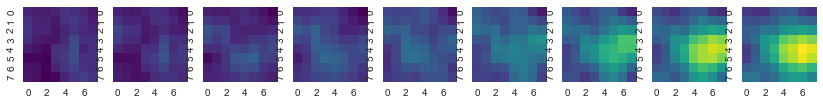

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


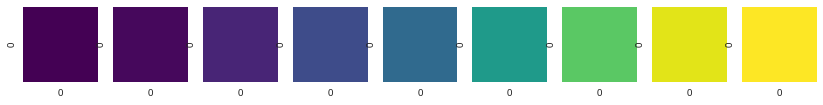

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


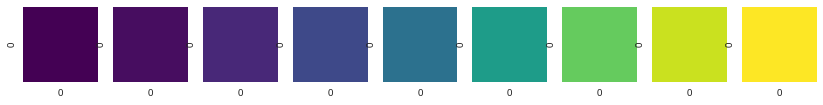

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


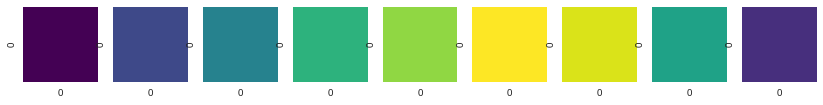

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


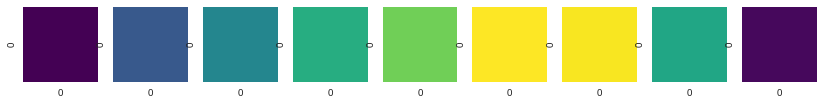

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   -1  | 11.090174674987793 | 0.155 | 0.044099997729063034 |
|   0   | 11.091815948486328 |  0.16 |  0.0478999987244606  |
|   1   | 11.095672607421875 | 0.175 | 0.07169999182224274  |
+-------+--------------------+-------+----------------------+


In [90]:
# 3d avg 1d avg max-min Laplacian edge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)